In [1]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.distribution_gif import gif_distrib_system_first_eig
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.basic_functions import position
from utils.basic_functions import copy_cat
from utils.basic_functions import plot_einselection
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.titlesize'] = 16             # Title font size
plt.rcParams['axes.titleweight'] = 'bold'       # Title font weight
plt.rcParams['axes.labelsize'] = 14             # X and Y label font size
plt.rcParams['axes.labelweight'] = 'bold'       # X and Y label font weight
#plt.rcParams['axes.grid'] = True                # Enable grid
#plt.rcParams['grid.alpha'] = 0.7                # Grid transparency
#plt.rcParams['grid.linestyle'] = '--'           # Grid line style
#plt.rcParams['grid.color'] = 'gray'             # Grid color

# Tick settings
plt.rcParams['xtick.labelsize'] = 12            # X tick label size
plt.rcParams['ytick.labelsize'] = 12            # Y tick label size
plt.rcParams['xtick.direction'] = 'in'          # X tick direction
plt.rcParams['ytick.direction'] = 'in'          # Y tick direction
plt.rcParams['xtick.major.size'] = 6            # X major tick size
plt.rcParams['ytick.major.size'] = 6            # Y major tick size

# Legend settings
plt.rcParams['legend.fontsize'] = 12            # Legend font size
plt.rcParams['legend.frameon'] = True           # Enable legend frame
plt.rcParams['legend.framealpha'] = 0.9         # Legend frame transparency
plt.rcParams['legend.loc'] = 'best'             # Legend location

# Line and marker settings
plt.rcParams['lines.linewidth'] = 2             # Line width
plt.rcParams['lines.markersize'] = 6            # Marker size

custom_colors = ['#1c4587', '#e6194B', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)


We investigate here the stability of pointer states. This is related to the question: "Do we need 3 systems to define pointer states?". Because if Schmidt states are defined up to a phase and that they converge to a pointer state and are rather stable once they reach it, then apparently I can find them with only 2 systems.

/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


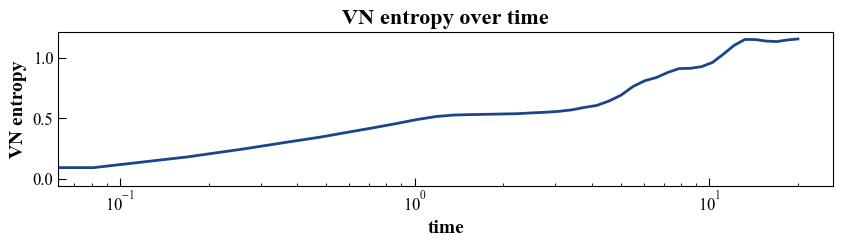

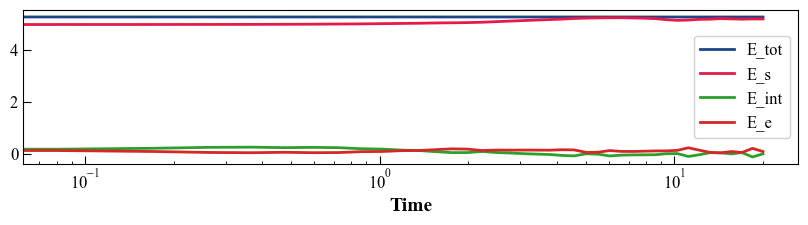

In [2]:
file_name = "coherent_state_decoherence"
d1, d2, E_s, E_s2, E_int_s, E_int_e, E_int_s2, E_int_e2, E_e, E_e2, envi, tmax, ind_nb, log = load_param(file_name)

#file_name="ACL_3_extended"
#d1, d2, E_s, E_s2, E_int_s, E_int_e, E_int_s2, E_int_e2, E_e, E_e2, w, envi, tmax, ind_nb, log = load_param(file_name)
info = load_param(file_name)
H_list=load_H_list(file_name)
result=load_result(file_name)
tlist=load_tlist(file_name)
plot_VN(result,tlist,1)
plt.show()
[E_tot,E_s,E_int,E_e]=exp_val_time(result, H_list, tlist)
plt.figure(figsize=(10, 2))
plt.plot(tlist,E_tot)
plt.plot(tlist,E_s)
plt.plot(tlist,E_int)
plt.plot(tlist,E_e)
plt.xscale("log")
plt.xlabel("Time")
plt.legend(["E_tot","E_s","E_int","E_e"])
plt.show()

#plot_hamiltonians(H_list)

In [13]:
import os


In [14]:
import pickle

def compute_and_save_schmidt_all_time(result, ind_nb, file_name):
    # Compute Schmidt states using the given function
    s_list = compute_schmidt_states_all_time(result, ind_nb)
    
    outputs_dir = "outputs/simulation_results"
    if not os.path.exists(outputs_dir):
        os.makedirs(outputs_dir)
    
    # Save s_list as a .pkl file using pickle
    with open(os.path.join(outputs_dir, f"s_list_{file_name}.pkl"), 'wb') as f:
        pickle.dump(s_list, f)
    
    print(f"Schmidt states have been saved to {outputs_dir} with the base filename '{file_name}'.")

compute_and_save_schmidt_all_time(result, ind_nb, file_name)

Schmidt states have been saved to outputs/simulation_results with the base filename 'coherent_state_decoherence'.


In [15]:
def load_schmidt(file_name):
    outputs_dir = "outputs/simulation_results"
    
    # Load s_list from its corresponding .pkl file using pickle
    with open(os.path.join(outputs_dir, f"s_list_{file_name}.pkl"), 'rb') as f:
        s_list = pickle.load(f)
    return s_list

In [16]:
s_list_loaded=load_schmidt(file_name)

In [6]:
s_list = compute_schmidt_states_all_time(result, ind_nb)
ss_list = s_list[0]
se_list = s_list[1]
sv_list = s_list[2]
s_full_list = s_list[3]


Need to investigate what are the pointer states's form? In the simpler ACL model they are just eigenstates of my hamiltonian. But in the more complex coherent state ACL, they might be less obvious. Then I need to investigate if they are stable or not.

In [ ]:
ss_list, se_list, sv_list, s_full_list = load_schmidt(file_name)
